In [ ]:
## Imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from audiolazy import str2midi, midi2str
!pip install midiutil
from midiutil import MIDIFile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=f8534bcdc56330f13c7f720e91e7d3b6082cfb4ba8b76731dd0485b9e8c89fe1
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built midiutil


In [ ]:
class ObjectPosition:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_dict(self):
        return {
            'x': self.x,
            'y': self.y,
        }

,x,y
0,360,951
1,1005,942
2,847,912
3,612,901
4,950,856
5,858,841
6,883,826
7,395,809
8,258,807
9,56,769


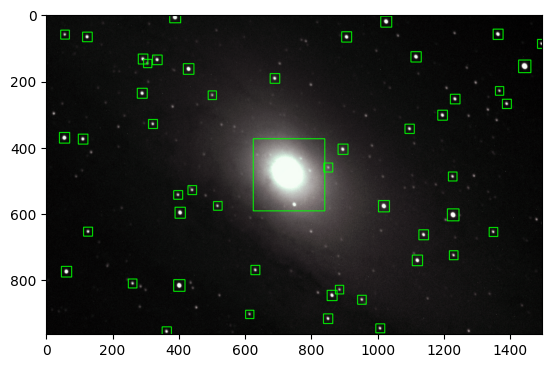

In [ ]:
lower_bound = 10
upper_bound = 100000

objects = []
# source data
img_file = "andronmeda(1).png"

# create an OpenCV image
img = cv2.imread(img_file)

# convert color image to grey image
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

im_gauss = cv2.GaussianBlur(gray_img, (5, 5), 0)
ret, thresh = cv2.threshold(im_gauss, 127, 255, 0)
# get contours
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

margin = 10
# calculate area and filter
for con in contours:
    area = cv2.contourArea(con)
    if lower_bound < area < upper_bound:
        x,y,w,h = cv2.boundingRect(con)
        objects.append(ObjectPosition(x, y))
        cv2.rectangle(img, (x-margin, y-margin), (x + w+margin, y + h+margin), (0,255,0), 2)

plt.imshow(img, cmap='gray')
df = pd.DataFrame.from_records([object.to_dict() for object in objects])
display(df)

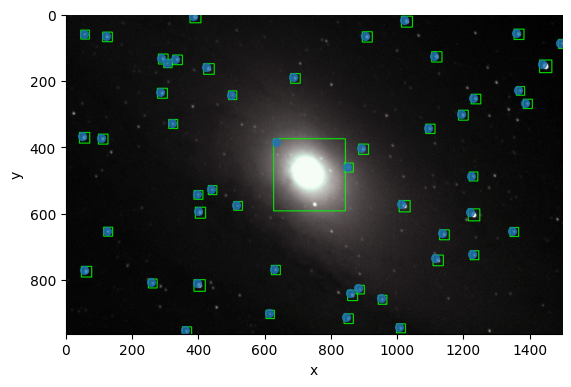

In [ ]:
# @title x vs y

from matplotlib import pyplot as plt
df.plot(kind='scatter', y='y', x='x', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.imshow(img, cmap='gray')

In [ ]:
# y = time
# x = pitch
# width = velocity


def map_value(value, min_value, max_value, min_result, max_result):
 # maps value (or array of values) from one range to another
 result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
 return result


duration_beats = 52.8 # how long in beats should this be

bpm = 128  #beats per minute
duration_sec = duration_beats*60/bpm #duration in seconds

print(duration_sec)

# C major scale
#note_names = ['C2','D2','E2','F2','G2','A2','B2',
 #            'C3','D3','E3','F3','G3','A3','B3',
 #            'C4','D4','E4','F4','G4','A4','B4']

# C lydian
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

# map midi notes to each of the notes I have selected
note_midis = [str2midi(n) for n in note_names]
n_notes = len(note_midis)

24.75


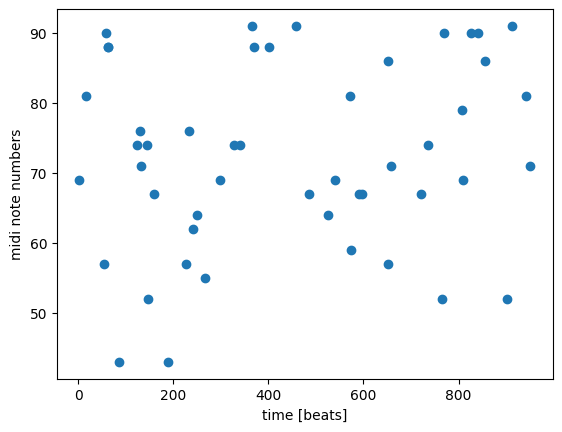

In [ ]:
midi_data = []

x_data = [obj.x for obj in objects] #pitch
t_data = [obj.y for obj in objects] #time

for i in range(len(x_data)):
    note_index = round(map_value(x_data[i], 0, 762, n_notes-1, 0))
    midi_data.append(note_midis[note_index])

plt.scatter(t_data, midi_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

In [ ]:
#create midi file object, add tempo
filename = 'test'
my_midi_file = MIDIFile(1) #one track
my_midi_file.addTempo(track=0, time=0, tempo=bpm)

#add midi notes
for i in range(len(t_data)):
    my_midi_file.addNote(track=0, channel=0, time=t_data[i]/4, pitch=midi_data[i], volume=127, duration=2)

#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f)